# Predict Electrical Energy Output of Combined Cycle Power Plant

### Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf

In [4]:
from sklearn.metrics import r2_score

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Problem Statement
A combined cycle power plant (CCPP) is an energy plant that converts a source of heat into mechanical energy. Predicting energy output of a power plant is important in order to maximize the profit from the available megawatt hours. In this project the goal is to predict the energy output of a CCPP with an artificial neural network (ANN). The dataset, which consists of these input and target variables, was collected over a six-year period.

## Data Analysis

In [6]:
dataset = pd.read_excel('data/Folds5x2_pp.xlsx')
dataset.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Features consist of hourly average ambient variables
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW
The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

### Summary of Data Frame

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


| Data set info: |  |
| :--- | :--- |
| Number of features | 4 |
| Number of examples | 9568 |
| Number of numerical features | 4 |
| Number of categorical features | 0 |
| Memory Usage | 373.9 KB |
| Target | `PE` |
| ML Problem Type | Regression |

### Descriptive statistics

#### Univariate Analysis

In [8]:
dataset.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


#### Bivariate Analysis

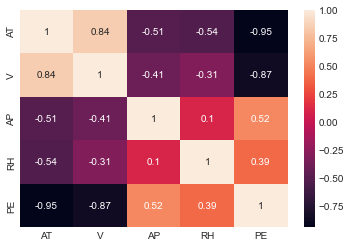

In [9]:
corr_matrix = dataset.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

## Statistical Graphical Techniques

### Displaying Univariate Numerical Data

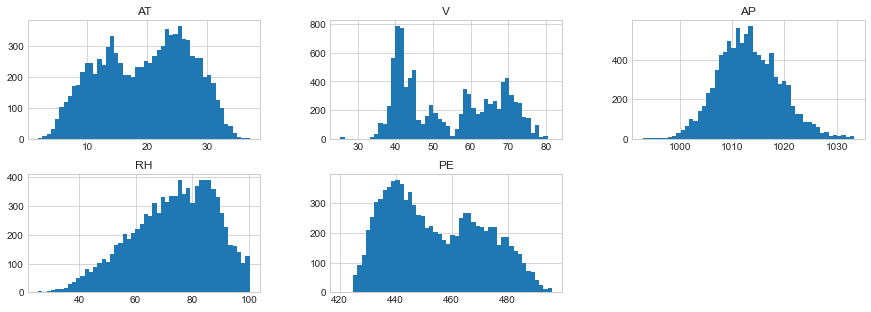

In [10]:
dataset.hist(figsize=(15,5), layout=(2,3), bins=50)
plt.show()

### Displaying Bivariate Numerical Data

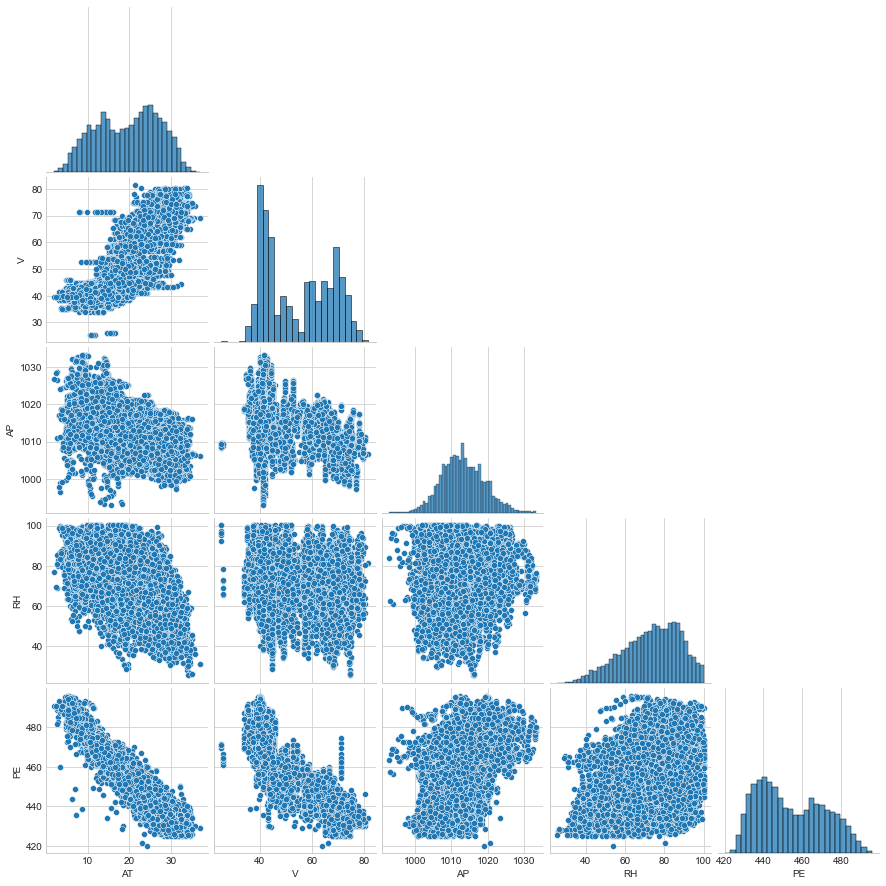

In [11]:
sns.pairplot(dataset, diag_kind='hist', corner=True)
plt.show()

### Splitting the dataset into Features and Target

In [12]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

### Splitting the dataset into the Training set and Test set

In [13]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size = 0.15, random_state = 0)

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size = 0.20, random_state = 0)

In [15]:
X_train.shape[0], X_valid.shape[0], X_test.shape[0]

(6505, 1627, 1436)

## Preprocessing

In [16]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
qt = QuantileTransformer(output_distribution='normal', random_state=0)
y_train_qt = qt.fit_transform(y_train.reshape(-1, 1))

In [17]:
sc = StandardScaler()
X_valid_std = sc.fit_transform(X_valid)

# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
qt = QuantileTransformer(output_distribution='normal', random_state=0)
y_valid_qt = qt.fit_transform(y_valid.reshape(-1, 1))

## Building the ANN

### Initializing the ANN

In [18]:
ann = tf.keras.models.Sequential([
    # first hidden layer
    tf.keras.layers.Dense(units=16, activation='relu'),
    
    # second hidden layer
    tf.keras.layers.Dense(units=32, activation='relu'),
    
    tf.keras.layers.Dense(units=32, activation='relu'),
    
    tf.keras.layers.Dense(units=16, activation='relu'),
    
    # output layer
    tf.keras.layers.Dense(units=1)
])

**NOTE:** `Dense` class:
```python
tf.keras.layers.Dense(
    units,
    activation=None,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)
```
The `Dense` class is just a densely-connected NN layer.

`Dense` implements the operation: `output = activation(dot(input, kernel) + bias)` where `activation` is the element-wise activation function passed as the `activation` argument, `kernel` is a weights matrix created by the layer, and `bias` is a bias vector created by the layer (only applicable if `use_bias` is `True`). These are all attributes of `Dense`.

More info: https://keras.io/api/layers/core_layers/dense/.

## Training the ANN

### Compiling the ANN

In [19]:
ann.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])

### EarlyStopping

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=15, # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001, # Minimum change in the monitored quantity to qualify as an improvement
    restore_best_weights=True, # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

### Training the ANN model on the Training set

In [21]:
history = ann.fit(X_train_std, y_train_qt,
                  validation_data=[X_valid_std, y_valid_qt],
                  batch_size=32,
                  callbacks=[early_stopping],
                  epochs=100)

Epoch 1/100
204/204 [==============================] - 1s 3ms/step - loss: 0.2757 - mean_squared_error: 0.2757 - val_loss: 0.1572 - val_mean_squared_error: 0.1572
Epoch 2/100
204/204 [==============================] - 1s 3ms/step - loss: 0.1321 - mean_squared_error: 0.1321 - val_loss: 0.1359 - val_mean_squared_error: 0.1359
Epoch 3/100
204/204 [==============================] - ETA: 0s - loss: 0.1248 - mean_squared_error: 0.12 - 1s 3ms/step - loss: 0.1247 - mean_squared_error: 0.1247 - val_loss: 0.1324 - val_mean_squared_error: 0.1324
Epoch 4/100
204/204 [==============================] - 0s 2ms/step - loss: 0.1200 - mean_squared_error: 0.1200 - val_loss: 0.1343 - val_mean_squared_error: 0.1343
Epoch 5/100
204/204 [==============================] - 1s 3ms/step - loss: 0.1195 - mean_squared_error: 0.1195 - val_loss: 0.1327 - val_mean_squared_error: 0.1327
Epoch 6/100
204/204 [==============================] - 1s 3ms/step - loss: 0.1190 - mean_squared_error: 0.1190 - val_loss: 0.1268 - v

Epoch 51/100
204/204 [==============================] - 1s 3ms/step - loss: 0.0961 - mean_squared_error: 0.0961 - val_loss: 0.1093 - val_mean_squared_error: 0.1093
Epoch 52/100
204/204 [==============================] - 1s 2ms/step - loss: 0.0959 - mean_squared_error: 0.0959 - val_loss: 0.1095 - val_mean_squared_error: 0.1095
Epoch 53/100
204/204 [==============================] - 1s 3ms/step - loss: 0.0977 - mean_squared_error: 0.0977 - val_loss: 0.1136 - val_mean_squared_error: 0.1136
Epoch 54/100
204/204 [==============================] - 1s 3ms/step - loss: 0.0965 - mean_squared_error: 0.0965 - val_loss: 0.1080 - val_mean_squared_error: 0.1080
Epoch 55/100
204/204 [==============================] - 1s 3ms/step - loss: 0.0973 - mean_squared_error: 0.0973 - val_loss: 0.1058 - val_mean_squared_error: 0.1058
Epoch 56/100
204/204 [==============================] - 1s 3ms/step - loss: 0.0970 - mean_squared_error: 0.0970 - val_loss: 0.1082 - val_mean_squared_error: 0.1082
Epoch 57/100
204

In [22]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,225
Trainable params: 2,225
Non-trainable params: 0
_________________________________________________________________


Best Validation Loss: 0.1047
Best Validation MSE: 0.1572


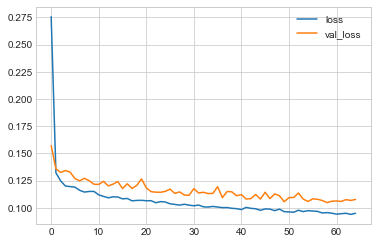

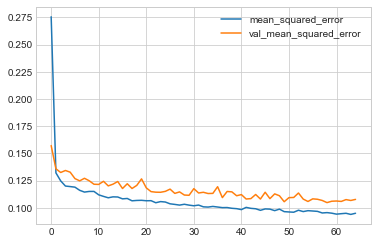

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['mean_squared_error', 'val_mean_squared_error']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation MSE: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_mean_squared_error'].max()))

### Predicting the results of the Test set

In [24]:
X_test_std = sc.transform(X_test)
y_test_qt = qt.transform(y_test.reshape(-1, 1))

In [25]:
y_pred = ann.predict(X_test_std)
R2 = np.round(r2_score(y_test_qt, y_pred), 4)
print(f'R2 score={R2}')

R2 score=0.9152


## References
1. Pınar Tüfekci, Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods, International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615, [Web Link](https://www.sciencedirect.com/science/article/abs/pii/S0142061514000908).
2. Heysem Kaya, Pınar Tüfekci , Sadık Fikret Gürgen: Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine, Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai)